In [1]:
%matplotlib widget
import numpy as np
import json, glob, copy
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from datetime import datetime

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from alvra_tools.XAS_functions import *
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_reduced_data(pgroup, loaddir, runlist):
    from collections import defaultdict
    titlestring = pgroup + ' --- ' +str(runlist)

    d = defaultdict(list)
    for run in runlist:
        data = {}
        file = glob.glob(loaddir + '/*{:04d}*/*run_array*'.format(run))
        run_array = np.load(file[0], allow_pickle=True).item()
        for k, v in run_array.items():
            for key, value in v.items():
                data[key] = value
                d[key].append(value)
                # if "scan" in key:
                #     d[key].extend(value)
                # else:
                #     d[key].extend(value)
    return d, titlestring

In [53]:
pgroup = 'p21533'
Loaddir_name = 'Reduced_YAG_2TTs'

runlist=np.arange(65, 90)
#runlist=[47]

##############################################
from textwrap import wrap
from sfdata import SFScanInfo

Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
print ('{} scans, {} total shots'.format(len(runlist), len(Delay_corr)))

[65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 89]
25 scans, 25 total shots


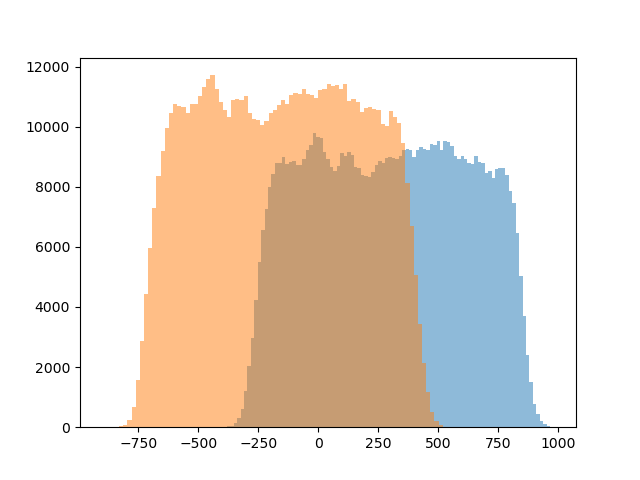

296.726593006765
-150.12837085944764


In [58]:
plt.figure()
plt.hist(np.hstack(Delay_corr), bins = 100, alpha = 0.5)
plt.hist(np.hstack(Delay_corr2), bins = 100, alpha = 0.5)
plt.show()

print (np.mean(np.hstack(Delay_corr)))
print (np.mean(np.hstack(Delay_corr2)))


In [59]:
quantile_band = 0.5
binsize = 2 # in fs

min_delay = -800
max_delay = 800

##############################################################
binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2
Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)

t0_fs_scan =[]
width_fs_scan = []

for index_run in range(len(Pump_probe_scan)):
    Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)
    #print (np.shape(Pump_probe_scan[index_run]),np.shape(Delay_corr[index_run]))
    pp_TT, binEdges, binNumber = binned_statistic(Delay_corr2[index_run], Pump_probe_scan2[index_run], statistic=np.nanmean, bins=binList)
    
    fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]

    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 4,200)
    fit.fit(Delay_fs_TT,pp_TT,maxfev=200000)
    
    t0_fs = fit.popt[0]
    width_fs = abs(fit.popt[2])
    
    t0_fs_scan.append(t0_fs)
    width_fs_scan.append(width_fs)

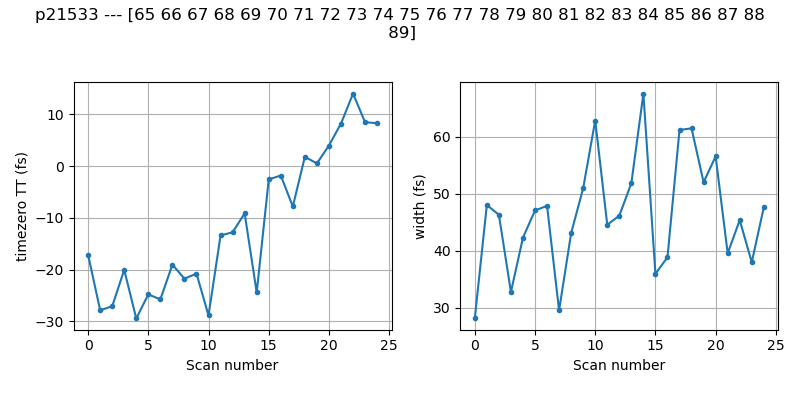

In [60]:
#scan_number = np.delete(np.array(range(123)), [0,65,109,110])

#t0_fs_scan_clean = np.delete(t0_fs_scan[:121], [107,108])
#width_fs_scan_clean = np.delete(width_fs_scan[:121], [107,108])

plt.figure(figsize = (8,4))
#plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))
plt.suptitle (titlestring_stack)


plt.subplot(121)
plt.plot(t0_fs_scan, marker='.')
plt.xlabel("Scan number")
plt.ylabel('timezero TT (fs)')
plt.grid()

plt.subplot(122)
#plt.plot(width_fs_scan, marker='.', label = 'Convolution fit')
plt.plot(width_fs_scan, marker='.', label = 'Derivative fit')

plt.xlabel('Scan number')
plt.ylabel('width (fs)')
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

FWHM_ave=np.mean(width_fs_scan)
FWHM_std=np.std(width_fs_scan)
#FWHM_ave


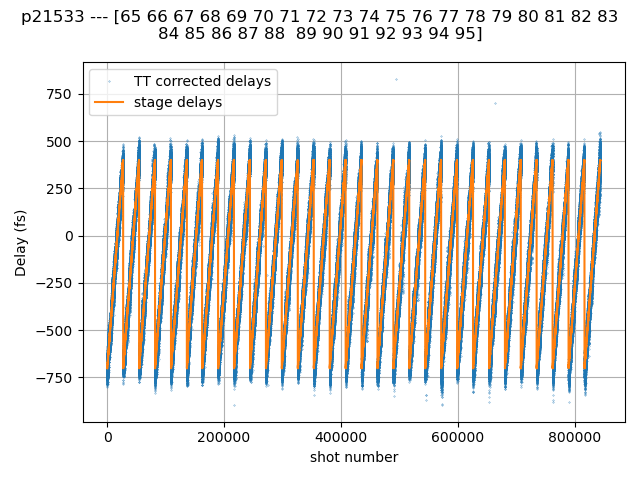

In [5]:
plt.figure()
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.plot(Delay_corr, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delay_fs, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.tight_layout()
plt.grid()
plt.show()

In [15]:
binsize = 2 # in fs

min_delay = -700
max_delay = 400

#####################################################################################################
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delay_corr))

binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2

Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delay_corr, Pump_probe_scan, statistic=np.nanmean, bins=binList)

(843618,) (843618,)


In [16]:
fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
Timezero_mm = get_timezero_NBS('/sf/alvra/data/p21533/raw/run0065-Water_IRF_2TT_loop_001/meta/scan.json')

index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
print(fit.p0)
fit.p0 = better_p0(fit.p0, 4,200)# overwrite some values (index) if needed: 
#fit.p0 =[0, 0.04, 50, 0.0, 500, 3e-5, 0.035]
#fit.p0 =[0, 0.04, 50, 0.0, 500]
print(fit.p0)

fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
t0_mm = Timezero_mm + fs2mm(t0_fs, 0)
width_fs = fit.popt[2]

print("Position t0 =",np.round(t0_mm,5),"mm")
#print("Width =",np.abs(np.round(width_mm,3))*1000,"um")
#print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

(-151.0, 0.004659093955536076, 2.0, -0.0015017300030218694, 0.25, 0, 0)
(-151.0, 0.004659093955536076, 2.0, -0.0015017300030218694, 200, 0, 0)
Position t0 = 202.82487 mm
Width = 61.71082 fs


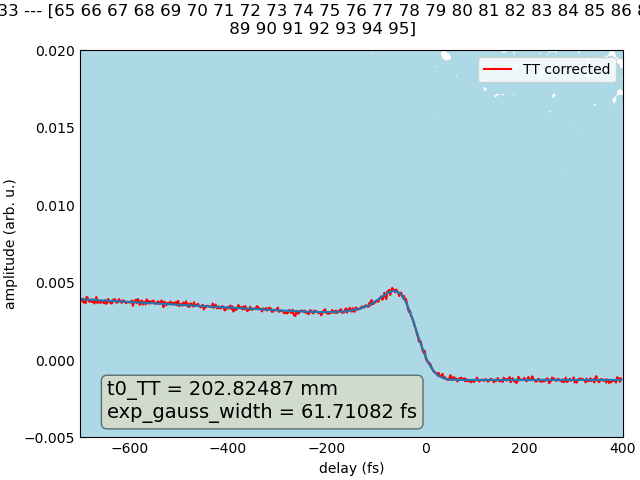

Position t0_raw = 202.82752000004498 mm
Position t0_TT = 202.82486628130846 mm


In [17]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(titlestring_stack)

plt.tick_params(direction='in')

plt.plot(Delay_corr, Pump_probe_scan, 'o', color='lightblue')#, markersize=0.5)
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
plt.plot(Delay_fs_TT, pp_fit)

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
                     r't0_TT = {} mm'.format(np.round(Timezero_mm + fs2mm(t0_fs,0),5)),
            r'exp_gauss_width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
plt.ylim(-0.005, 0.02)
plt.xlim(-700, 400)
plt.grid()
plt.show()

print("Position t0_raw = {} mm".format(Timezero_mm ))
print("Position t0_TT = {} mm".format(Timezero_mm + fs2mm(t0_fs,0)))

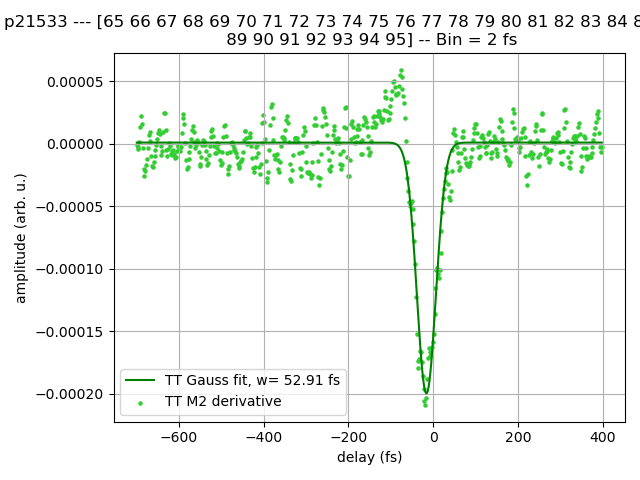

[-1.62919136e+01 -2.00754681e-04 -2.24661389e+01  9.91012899e-07]


In [19]:
pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0,-55, 0])

plt.figure()
plt.title(titlestring_stack+ ' -- Bin = {} fs'.format(binsize))
plt.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
plt.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'TT Gauss fit, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

plt.legend(loc='lower left')

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.grid()
plt.tight_layout()
plt.show()

print(parameters_M2)

In [76]:
pgroup = 'p21533'
Loaddir_name = 'Reduced_YAG_2TTs'

runlist=np.arange(65, 91)
#runlist=[47]

##############################################
from textwrap import wrap
from sfdata import SFScanInfo

Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
print ('{} scans, {} total shots'.format(len(runlist), len(Delay_corr)))

[65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 89 90]
26 scans, 26 total shots


In [77]:
quantile_band = 0.5
binsize = 20 # in fs

min_delay = -800
max_delay = 800


##############################################################
from scipy.stats import binned_statistic
binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2

t0_fs_scan_124 =[]
width_fs_scan_124 = []
t0_fs_scan_126 =[]
width_fs_scan_126 = []

for index_run in range(len(Pump_probe_scan)):
    Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)
    
    #print (np.shape(Pump_probe_scan[index_run]),np.shape(Delay_corr[index_run]))
    pp_TT_126, binEdges, binNumber = binned_statistic(Delay_corr2[index_run], Pump_probe_scan2[index_run], statistic='mean', bins=binList)
    
    #print (np.shape(Pump_probe_scan2[index_run]),np.shape(Delay_corr2[index_run]))
    pp_TT_124, binEdges, binNumber = binned_statistic(Delay_corr[index_run], Pump_probe_scan[index_run], statistic='mean', bins=binList)
    
    fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_126))
    Delay_fs_TT_126 = Delay_fs_TT[index]
    pp_TT_126 = pp_TT_126[index]

    fit.estimate(Delay_fs_TT_126, pp_TT_126)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 4,200)
    fit.fit(Delay_fs_TT_126,pp_TT_126,maxfev=200000)
    
    t0_fs = fit.popt[0]
    width_fs = abs(fit.popt[2])
    t0_fs_scan_126.append(t0_fs)
    width_fs_scan_126.append(width_fs)
    
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_124))
    Delay_fs_TT_124 = Delay_fs_TT[index]
    pp_TT_124 = pp_TT_124[index]

    fit.estimate(Delay_fs_TT_124, pp_TT_124)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 4,200)
    fit.fit(Delay_fs_TT_124,pp_TT_124,maxfev=200000)
    
    t0_fs = fit.popt[0]
    width_fs = abs(fit.popt[2])
    t0_fs_scan_124.append(t0_fs)
    width_fs_scan_124.append(width_fs)

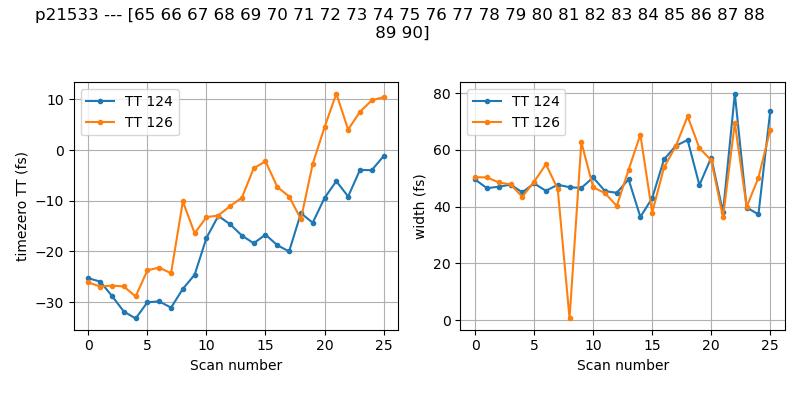

In [78]:
plt.figure(figsize = (8,4))
#plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))
plt.suptitle (titlestring_stack)


plt.subplot(121)
plt.plot(np.array(t0_fs_scan_124)-455, marker='.', label = 'TT 124')
plt.plot(t0_fs_scan_126, marker='.', label = 'TT 126')
#plt.plot(-np.array(t0_fs_scan_126) + np.array(t0_fs_scan_124)-455, marker='.', label = 'difference')
plt.xlabel("Scan number")
plt.ylabel('timezero TT (fs)')
plt.legend(loc='best')
plt.grid()

plt.subplot(122)
#plt.plot(width_fs_scan, marker='.', label = 'Convolution fit')
plt.plot(width_fs_scan_124, marker='.', label = 'TT 124')
plt.plot(width_fs_scan_126, marker='.', label = 'TT 126')

plt.legend(loc='best')
plt.xlabel('Scan number')
plt.ylabel('width (fs)')
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
